In [144]:
import json
import pandas as pd
import numpy as np
from yome import Session
from yome.models import *
from yome.util import to_df
import re
from sqlalchemy.orm import aliased
import itertools as it
import seaborn as sns
from IPython.display import HTML

In [145]:
pd.set_option('display.max_colwidth', -1)

In [146]:
from mpl_recipes import mpl_setup
%mpl_setup

Populating the interactive namespace from numpy and matplotlib


In [147]:
session = Session()

# Functions

In [148]:
def report(locus_tag):
    # Get TBD genes for EcoGene but high for Eco
    report = to_df(
        session.query(Gene.locus_id,
                      KnowledgebaseGene.primary_name,
                      KnowledgebaseGene.annotation_quality,
                      Knowledgebase.name.label('knowledgebase_name'),
                      KnowledgebaseFeature.feature_type,
                      KnowledgebaseFeature.feature)
        .join(KnowledgebaseGene)
        .join(Knowledgebase)
        .join(KnowledgebaseFeature)
        .filter(Gene.locus_id == locus_tag)
    )

    print(report.iloc[0, 0:2])

    report.knowledgebase_name = report.apply(lambda row: f"{row['knowledgebase_name']} ({row['annotation_quality']})", axis=1)
    report = report.drop(['locus_id', 'primary_name', 'annotation_quality'], axis=1)
    report = report.set_index(['knowledgebase_name', 'feature_type'])
    s = report.style.set_properties(**{'text-align': 'left'})
    return HTML(s.render())

# Genes without b-number

In [149]:
# Genes b4309 pseudo in EcoGene
no_b_number = to_df(
    session.query(KnowledgebaseGene.primary_name,
                  KnowledgebaseGene.annotation_quality,
                  Knowledgebase.name.label('kb_name'))
    .join(Knowledgebase)
    .filter(KnowledgebaseGene.gene_id == None)
)

In [150]:
no_b_number.groupby('kb_name').agg('count')

,primary_name,annotation_quality
kb_name,,
EcoCyc,55,55
UniProt,1,1


# Find locus tags with multiple genes

In [151]:
KnowledgebaseGene2 = aliased(KnowledgebaseGene)

In [152]:
duplicates = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseGene2.primary_name.label('primary_name2'),
                  Knowledgebase.name)
    .join(KnowledgebaseGene, KnowledgebaseGene.gene_id == Gene.id)
    .join(KnowledgebaseGene2, KnowledgebaseGene2.gene_id == Gene.id)
    .join(Knowledgebase, KnowledgebaseGene.knowledgebase_id == Knowledgebase.id)
    .filter(KnowledgebaseGene2.knowledgebase_id == Knowledgebase.id)
    .filter(KnowledgebaseGene.id != KnowledgebaseGene2.id)
)

In [153]:
duplicates

,locus_id,primary_name,primary_name2,name
0,b3504,yhiS_2,yhiS_1,EcoCyc
1,b0240,crl_1,crl_2,EcoCyc
2,b0240,crl_2,crl_1,EcoCyc
3,b3504,yhiS_1,yhiS_2,EcoCyc
4,b4581,ybeM,ybeH,UniProt
5,b4581,ybeH,ybeM,UniProt


# Kbase comparison plot
NOTE: 55 EcoCyc & 1 UniProt genes without a locus tag and 2 EcoCyc and 1 Uniprot genes with duplicated locus tags are ignored in this plot

In [154]:
kbases = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseGene.annotation_quality,
                  Knowledgebase.name.label('knowledgebase_name'))
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
)

In [155]:
# high quality EcoCyc evidence should override everything, e.g. b0089 / ftsW 
ecocyc_evidence = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseFeature.feature)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .join(KnowledgebaseFeature)
    .filter(Knowledgebase.name == 'EcoCyc')
    .filter(KnowledgebaseFeature.feature_type == 'evidence_html')
)
ecocyc_evidence_has_assay = ecocyc_evidence[ecocyc_evidence.feature.str.contains('assay', flags=re.IGNORECASE)
                                            | ecocyc_evidence.feature.str.contains('reaction blocked in mutant', flags=re.IGNORECASE)
                                            | ecocyc_evidence.feature.str.contains('traceable author statement to experimental support', flags=re.IGNORECASE)]

In [156]:
# high quality EcoCyc evidence should override everything, e.g. b0089 / ftsW 
ecocyc_insertion = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseFeature.feature)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .join(KnowledgebaseFeature)
    .filter(Knowledgebase.name == 'EcoCyc')
    .filter(KnowledgebaseFeature.feature_type == 'is_insertion_element')
)
ecocyc_is_insertion = ecocyc_insertion[ecocyc_insertion.feature == 't']

In [157]:
def calculate_y_ome(row):
    any_high =     any(x == 'high'     for x in row)
    any_low =      any(x == 'low'      for x in row)
    any_excluded = any(x == 'excluded' for x in row)
    # good results when EcoCyc and UniProt agree
    ecocyc_uniprot_high = (row['EcoCyc'] == 'high' and row['UniProt'] == 'high')
    # high quality EcoCyc evidence should override everything, e.g. b0089 / ftsW 
    has_experimental_assay = row.name in ecocyc_evidence_has_assay.locus_id.values
    # RegulonDB should override everything
    regulon_db_high = row['RegulonDB'] == 'high'
    # Insertion element call overrides everything
    is_insertion = row.name in ecocyc_is_insertion.locus_id.values
    
    return (
        'high'          if ( has_experimental_assay or 
                             regulon_db_high or 
                             ecocyc_uniprot_high or
                             is_insertion or
                            (any_high     and not any_low  and not any_excluded))
        else 'low'      if ( any_low      and not any_high and not any_excluded)
        else 'excluded' if ( any_excluded )
        else 'tbd'
    )

In [158]:
# remove duplicate genes
kbases_unstacked = kbases.set_index(['locus_id', 'knowledgebase_name'])
kbases_unstacked = kbases_unstacked[~kbases_unstacked.index.duplicated(keep='first')]
kbases_unstacked = kbases_unstacked.drop('primary_name', axis=1).unstack()
kbases_unstacked.columns = kbases_unstacked.columns.droplevel(0)

In [159]:
# calculate Y-ome; don't rely on ME-model
kbases_unstacked['Y-ome'] = kbases_unstacked[kbases_unstacked.columns.drop('iJL1678b')].apply(calculate_y_ome, axis=1)

In [160]:
# Y-ome counts
kbases_unstacked['Y-ome'].value_counts()

high        2650
low         1470
excluded    307 
tbd         226 
Name: Y-ome, dtype: int64

In [161]:
# get list of genes starting with y in EcoCyc
# high quality EcoCyc evidence should override everything, e.g. b0089 / ftsW 

In [162]:
ecocyc_names = {x[0]: x[1] for x in (
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .filter(Knowledgebase.name == 'EcoCyc')
).all()}

In [163]:
def starts_y(row):
    primary_name = ecocyc_names.get(row.name, None)
    return 'low' if primary_name and primary_name.startswith('y') \
        else 'high' if primary_name \
        else 'excluded'

In [164]:
kbases_unstacked['starts_y'] = kbases_unstacked.apply(starts_y, axis=1)

In [165]:
levels = {
    'excluded': 0,
    'tbd': 1,
    'low': 2,
    'high': 3,
    None: 4
}

In [166]:
colors = {
    0: [ 0.85453713,  0.22957019,  0.27623218,  1.        ], # bright red
    1: [ 0.9170408 ,  0.56061475,  0.58722664,  1.        ], # red
    2: [ 0.57653009,  0.72175186,  0.76633449,  1.        ], # light blue green
    3: [ 0.24715576,  0.49918708,  0.57655991,  1.        ], # dark blue green
    4: [ 0.6,         0.6,         0.6,         1.        ], # grey
}
# pal = sns.diverging_palette(10, 220, sep=80, n=7)
# sns.palplot(pal)
# pal

In [167]:
knowledgebase_names = list(kbases_unstacked.columns)
kbases_plot = kbases_unstacked.applymap(lambda x: levels[x]).sort_values(by=list(kbases_unstacked.columns))

In [168]:
# create bars based on consecutive colors
last_value = {kbase: None for kbase in knowledgebase_names}
bars = {kbase: [] for kbase in knowledgebase_names}
for locus_tag, row in kbases_plot.iterrows():
    for kbase, value in row.iteritems():
        if len(bars[kbase]) == 0 or bars[kbase][-1]['value'] != value:
            bars[kbase].append({'value': value, 'height': 1})
            last_value[kbase] = value
        else:
            bars[kbase][-1]['height'] += 1

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


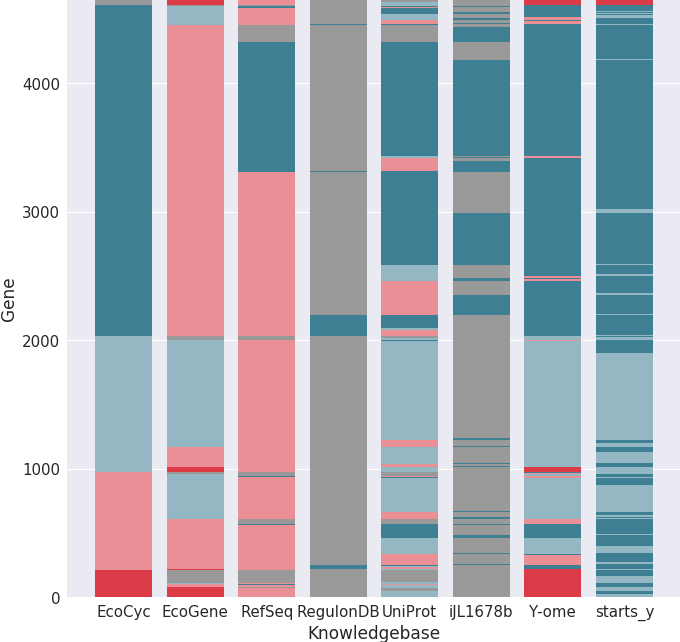

In [169]:
fig, ax = plt.subplots(figsize=(11, 11))
last_heights = [0 for _ in knowledgebase_names]
for bar_list in it.zip_longest(*bars.values()):
    left = [x + 0.1 for x in range(len(knowledgebase_names))]
    height = [x['height'] if x is not None else 0 for x in bar_list]
    bottom = last_heights
    last_heights = [x + y for x, y in zip(height, last_heights)]
    color = [colors[x['value']] if x is not None else 'k' for x in bar_list]
    ax.bar(left, height, bottom=bottom, color=color, linewidth=0)
ax.set_xlabel('Knowledgebase')
ax.set_ylabel('Gene')
ax.xaxis.set_ticks([x + 0.1 for x in range(len(kbases_plot.columns))])
ax.xaxis.set_ticklabels(kbases_plot.columns)
fig.savefig('/Users/zaking/lab/y-ome/figs/y-ome-latest.png')

# cases to check:

### High in one DB, low in another

+ High in EcoCyc and low in EcoGene
  + result: based on *caiC*, give "high" priority over "low" because EcoCyc has more up-to-date information for "high" cases
+ High in UniProt and low in EcoCyc
  + result: based on *yadI / b0129*, don't rely on EC number in UniProt; use annotation score instead
  + result: based on *mrdB*, don't categorize "family protein" as poor annotation in EcoCyc
  + result: based on *YdcE / b1461*, UniProt high should override EcoCyc because EcoCyc missed the experimental validation in the linked paper (good example for the text)
  + result: based on *dgcJ / b1786*, uniprot level 5 annotation should be "low", because even putative functions are given this level of annotation (also a good example for the text)
+ High in ME-model, low in EcoCyc
  + result: ME-model includes putative annotations (e.g. YaaJ). Don't mark these as high
  + TODO provide an analysis of them in the text
+ High in EcoCyc and low in UniProt
  + result: based on thrL; UniProt got this one wrong, should be high
+ dicuss how to prefer b0240 / crl to `_1` and `_2` 
  + https://biocyc.org/gene?orgid=ECOLI&id=G0-16683
  + https://biocyc.org/gene?orgid=ECOLI&id=G0-16684
  + https://biocyc.org/gene?orgid=ECOLI&id=EG11092
  + one solution: devote a paragraph to the discussin in https://biocyc.org/gene?orgid=ECOLI&id=EG11092, noting that UniProt marks this one as "high", and EcoCyc marks it as a pseudogene even though there is a clear function
+ consider EcoCyc 'family protein' as a low keyword
  + result: would only have re-categorized fepE / b0587

### Other E. coli evidence tags

+ "gene expression analysis" is promising, but a number of transcription factors in E. coli have this evidence, but do not have known conditions of binding or binding targets. E.g. yeiL / b2163 and adiY / b4116
+ "inferred by functional complementation" is used with poorly characterized genes like b2952 / yggT
+ "binding of purified proteins" doesn't catch anything new
+ "Inferred from genetic interaction" will get b0461 wrong
+ "Author hypothesis" is too vague
+ "inferred from mutant phenotype" appears on lots of poorly annotated genes, e.g. dctR / b3507
+ 'phage or prophage related' in EcoGene does not mean uncharacterized. e.g. icd / b1136

### Genes where Y-ome disagrees with EcoCyc

Result: After spot-checking a number of cases where EcoCyc is not in agreement with the final Y-ome:

- pseudogenes called by EcoGene are just listed as poorly characterized genes in EcoCyc (OK)
- UniProt gives annotation scores to help clarify annotation for a number of genes. These are present and annotated in EcoCyc, but the annotation level cannot be determined automatically (OK)

### TODO bring in regulonDB


## Assertions
The literature points to a particular answer for these genes

In [330]:
assertions = pd.read_table('../sources/manual/manual.tsv', sep='\t', index_col='locus_tag')

# these differences check out
ok = ['b0268', 'b1695', 'b2844', 'b0240']

# Check for any incorrect assertions
def check_for_row(row):
    return any(row.name == locus_tag and row['Y-ome'] != val and row['Y-ome'] != 'tbd' and val != 'read' and locus_tag not in ok
               for locus_tag, val in assertions.new_qual.iteritems())
res = kbases_unstacked[kbases_unstacked.apply(check_for_row, axis=1)]
print(res)
assert(len(res) == 0)

Empty DataFrame
Columns: [EcoCyc, EcoGene, RefSeq, RegulonDB, UniProt, iJL1678b, Y-ome, starts_y]
Index: []


In [331]:
tbd = kbases_unstacked[(kbases_unstacked['Y-ome'] == 'tbd') & ~kbases_unstacked.index.isin(assertions.index)]
tbd_locus_tag = tbd.index[1]
print(f'{len(tbd)} genes; next locus: {tbd_locus_tag}')

kbases_unstacked[kbases_unstacked.index == tbd_locus_tag]

49 genes; next locus: b4424


knowledgebase_name,EcoCyc,EcoGene,RefSeq,RegulonDB,UniProt,iJL1678b,Y-ome,starts_y
locus_id,,,,,,,,
b4424,tbd,tbd,None,None,None,None,tbd,high


In [332]:
report(tbd_locus_tag)

locus_id        b4424
primary_name    rdlC 
Name: 0, dtype: object


# check on evidence type

In [175]:
ev = to_df(
    session.query(
        Gene.locus_id,
        KnowledgebaseGene.primary_name,
        KnowledgebaseFeature.feature,
    )
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .join(KnowledgebaseFeature)
    .filter(Knowledgebase.name == 'EcoCyc')
    .filter(KnowledgebaseFeature.feature_type == 'description')
    .filter(KnowledgebaseFeature.feature.ilike('%domain-containing protein%'))
)

In [176]:
evm = ev.merge(kbases_unstacked, left_on='locus_id', right_index=True) #['Y-ome'].value_counts()
evm[evm['Y-ome'] == 'tbd']

,locus_id,primary_name,feature,EcoCyc,EcoGene,RefSeq,RegulonDB,UniProt,iJL1678b,Y-ome,starts_y
39,b1088,yceD,DUF177 domain-containing protein YceD,tbd,tbd,tbd,None,tbd,None,tbd,low
145,b2144,sanA,DUF218 domain-containing protein SanA,tbd,tbd,tbd,None,tbd,None,tbd,high
150,b3362,yhfG,DUF2559 domain-containing protein YhfG,high,low,tbd,None,low,None,tbd,low


In [177]:
report('b0240')

locus_id        b0240
primary_name    crl_1
Name: 0, dtype: object


ValueError: style is not supported for non-unique indicies.